In [1]:
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pdr
from marslab.bandset.mastcamz import ZcamBandSet, ls_zcam
from marslab.imgops.masking import skymask, threshold_mask

from roi_classifier import (
    SHARED_BAND_INDEX,
    add_rois,
    apply_homography,
    apply_kmeans_to_masked,
    average_spectra,
    filter_connected_components,
    mask_cube,
    plot_spectra,
    trim_margins,
    load_data,
)
from pdr.pds4_tools.extern.zscale import zscale

### Load, Pre-process cube

In [2]:
CAMERA_FILTERS = {
    'L': [
        'L0R',
        'L0G',
        'L0B',
        'L1',
        'L2',
        'L3',
        'L4',
        'L5',
        'L6'
    ],
    'R': [
        'R0R',
        'R0G',
        'R0B',
        'R1',
        'R2',
        'R3',
        'R4',
        'R5',
        'R6'
    ]
}

# load, debayer data
SEARCH_PATH = Path("data/new/1164/3")
bs = ZcamBandSet(ls_zcam(SEARCH_PATH))
bs.load("all")
bs.bulk_debayer("all")

# load left and right data cubes
l_cube = np.array([bs.get_band(band) for band in CAMERA_FILTERS['L']])
r_cube = np.array([bs.get_band(band) for band in CAMERA_FILTERS['R']])

In [3]:
# new loading functionality will go here...
# NOTE: this is not plugged into anything yet
cube = load_data("data/new/1164/3")

In [4]:
l_cube.shape

(9, 1200, 1648)

In [5]:
r_cube.shape

(9, 1200, 1648)

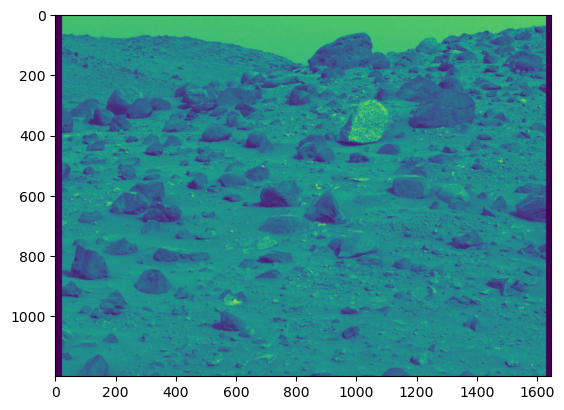

In [6]:
plt.imshow(l_cube[0])

In [7]:
# trim margins off of raw cubes
r_cube_trimmed = trim_margins(r_cube)
l_cube_trimmed = trim_margins(l_cube)

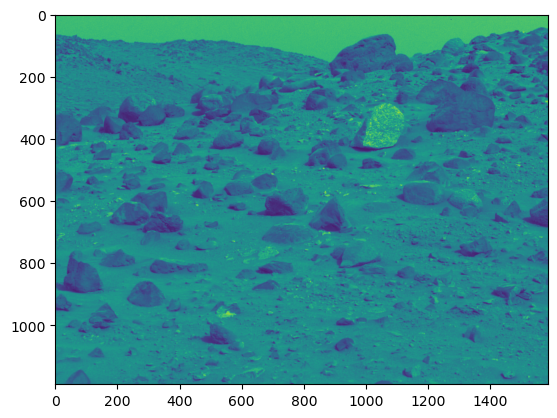

In [8]:
plt.imshow(r_cube_trimmed[0])

In [9]:
l_cube_mapped = apply_homography(l_cube_trimmed, r_cube_trimmed)

In [10]:
l_cube_mapped.shape

(9, 1190, 1585)

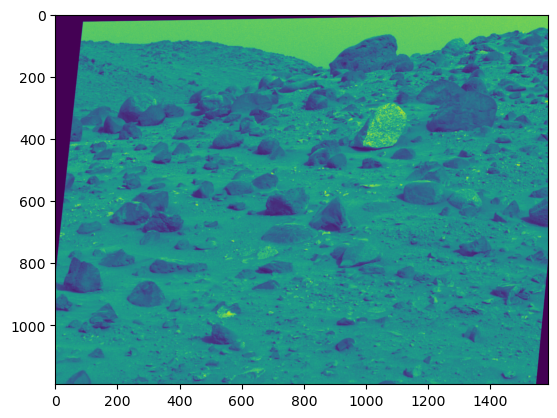

In [11]:
plt.imshow(l_cube_mapped[0])

In [12]:
full_cube = []

# average left/right views of Bayer and 800nm bands
for band in range(SHARED_BAND_INDEX+1):
    img = (l_cube_mapped[band] + r_cube_trimmed[band]) / 2
    full_cube.append(img)

# add left bands
l_num_bands = l_cube_trimmed.shape[0]
for band in range(SHARED_BAND_INDEX+1, l_num_bands):
    full_cube.append(l_cube_mapped[band])

# add right bands
r_num_bands = r_cube_trimmed.shape[0]
for band in range(SHARED_BAND_INDEX+1, r_num_bands):
    full_cube.append(r_cube_trimmed[band])

full_cube = np.array(full_cube)

In [13]:
full_cube.shape

(14, 1190, 1585)

### Masking shaddows and sky

In [14]:
def mask(cube, shaddow_threshold):
    # mask shaddows
    shaddow_tmask = threshold_mask(cube, shaddow_threshold, operator='and')
    
    slice = cube[3][np.newaxis, :]
    cube_preprocessed = np.ma.masked_array(slice, mask=shaddow_tmask)
    return cube_preprocessed[0]

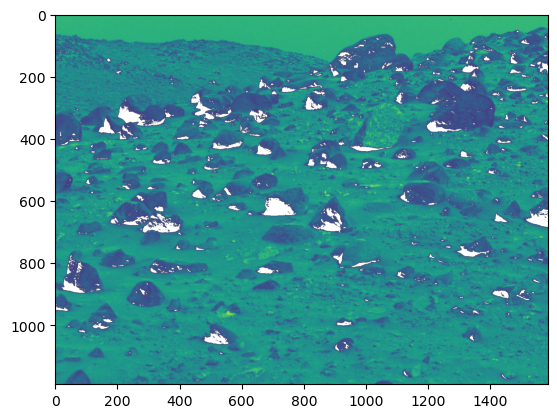

In [15]:
shaddow_tmask = threshold_mask(r_cube_trimmed, (7, 100), operator='and')
img = np.ma.masked_array(r_cube_trimmed[3], mask=shaddow_tmask)

plt.imshow(img)

In [16]:
# TODO: this is wrong... will use ASD
def mask_bad_pixels(cube):
    band_slice = cube[SHARED_BAND_INDEX]
    low, high = zscale(band_slice)
    mask = (band_slice >= low) & (band_slice <= high)
    return mask

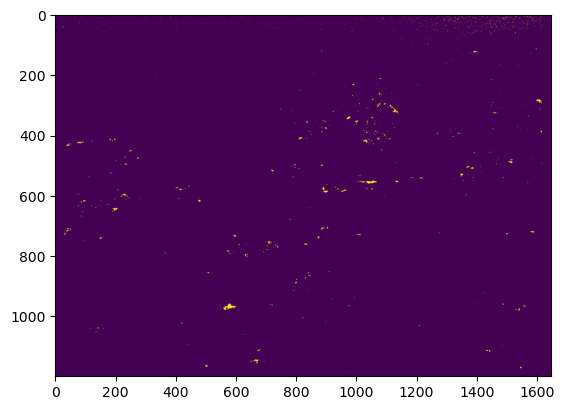

In [17]:
test_mask = mask_bad_pixels(r_cube)
plt.imshow(~test_mask)

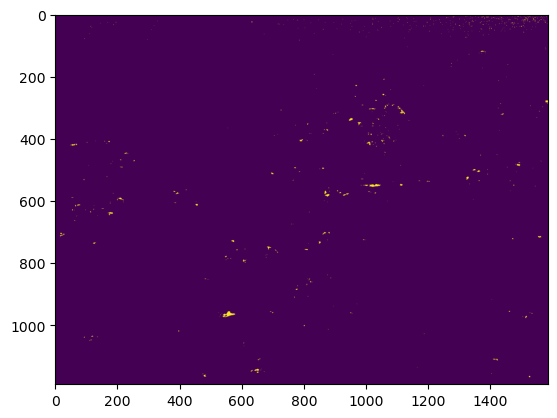

In [18]:
test_mask = mask_bad_pixels(l_cube_mapped)
plt.imshow(~test_mask)

In [19]:
# mask shaddows
shaddow_tmask = threshold_mask(r_cube_trimmed, (7, 100), operator='and')

# mask the sky
skymask_kwargs = {
    'percentile': 75,
    'edge_params': {"maximum": 5, "erosion": 3},
    'input_median': 5,
    'trace_maximum': 5,
    'cutoffs': {
        "extent": 0.05, "coverage": None, "v": 0.9, "h": None
        },
    'input_mask_dilation': None,
    'input_stretch': (10, 1),
    'floodfill': True,
    'trim_params': {"trim": False},
    'clear': True,
    'colorblock': False,
    'respect_mask': False,
}
sky_tmask = skymask(r_cube_trimmed, **skymask_kwargs)

# mask the overlap bewteen the cameras
overlap_mask = (l_cube_mapped[SHARED_BAND_INDEX] == 0)

# mask bad pixels
l_bad_pixels = ~mask_bad_pixels(l_cube_mapped)
r_bad_pixels = ~mask_bad_pixels(r_cube_trimmed)

# combine the masks into one
full_tmask = shaddow_tmask | sky_tmask | overlap_mask | l_bad_pixels | r_bad_pixels

cube_preprocessed = mask_cube(full_cube, full_tmask)

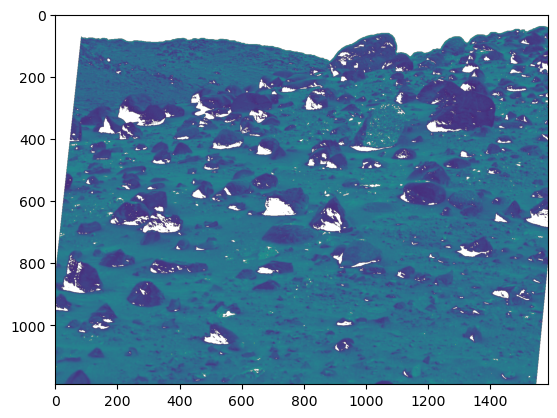

In [20]:
plt.imshow(cube_preprocessed[12])

### Identify small surfaces

In [21]:
clustered = apply_kmeans_to_masked(cube_preprocessed, k=5)

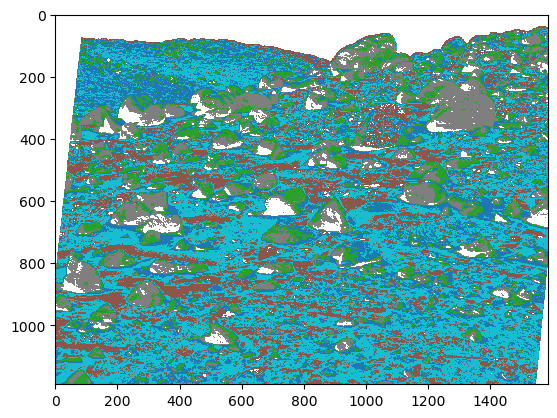

In [22]:
plt.imshow(clustered, cmap='tab10', interpolation='nearest')

In [23]:
float_rock_mask = filter_connected_components(clustered, 6000, 20000)

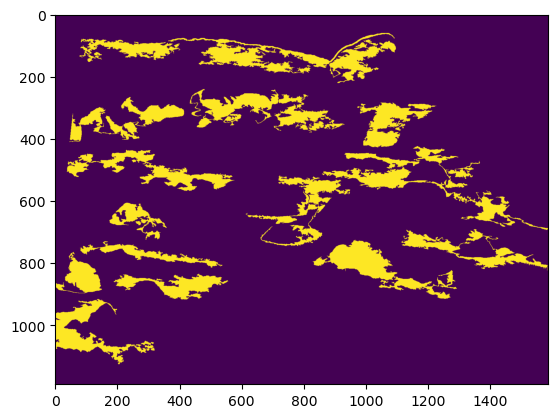

In [24]:
plt.imshow(float_rock_mask)

### Create seprate masks for large and small surfaces

In [25]:
# compute cube prioritizing large surfaces
l_surfs_mask = np.logical_or(float_rock_mask, full_tmask)
l_surfs = mask_cube(cube_preprocessed, l_surfs_mask)

# compute cube prioritizing small surfaces
s_surfs_mask = np.logical_or(~float_rock_mask, full_tmask)
s_surfs = mask_cube(cube_preprocessed, s_surfs_mask)

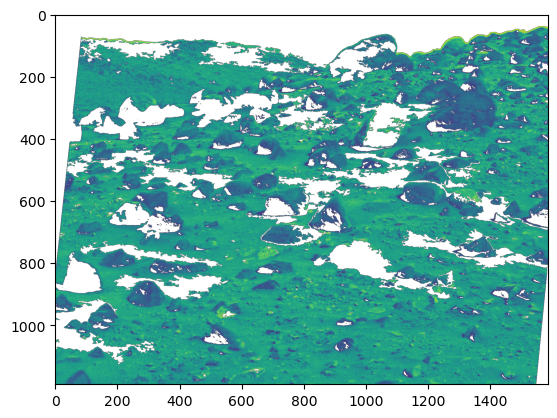

In [26]:
plt.imshow(l_surfs[0])

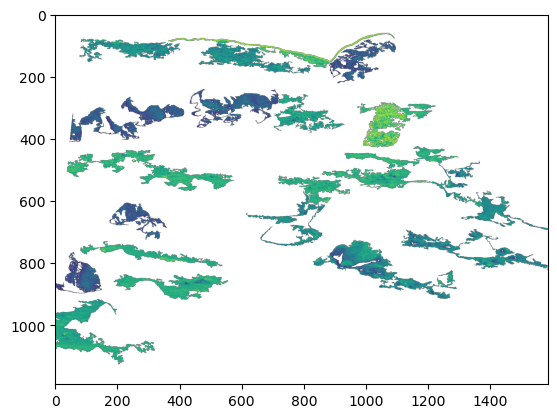

In [27]:
plt.imshow(s_surfs[0])

### Cluster large/small surface masks

In [28]:
l_clustered = apply_kmeans_to_masked(l_surfs, k=10)
s_clustered = apply_kmeans_to_masked(s_surfs, k=7)

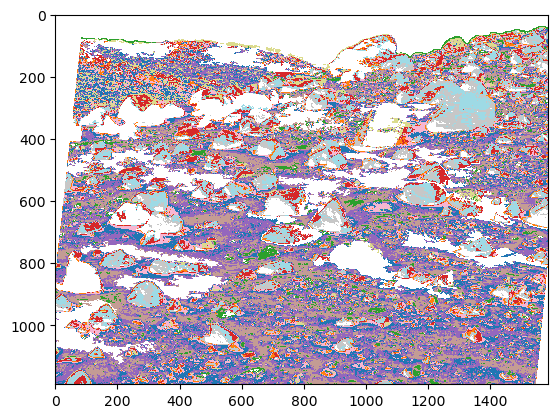

In [29]:
plt.imshow(l_clustered, cmap='tab20', interpolation='nearest')

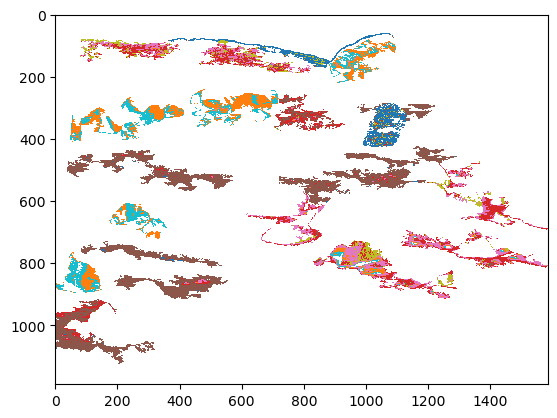

In [30]:
plt.imshow(s_clustered, cmap='tab10', interpolation='nearest')

### Identify ROI in classifications

In [31]:
s_rois = add_rois(s_clustered, min_region_sz=500, max_region_sz=8000, center_thresh_dif=1000, density_threshold=0.9)
l_rois = add_rois(l_clustered, min_region_sz=500, max_region_sz=8000, center_thresh_dif=1000, density_threshold=0.9)


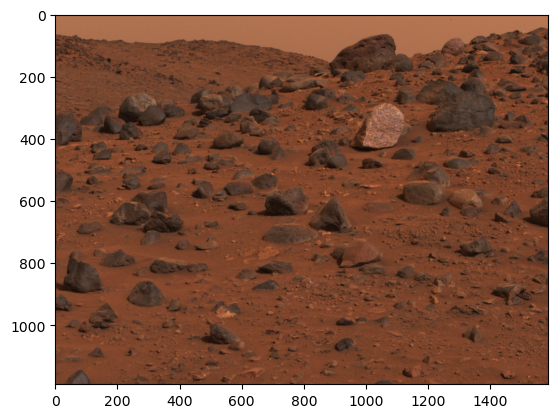

In [32]:
# creates rgb image from right bayer bands
red = r_cube_trimmed[0]
green = r_cube_trimmed[1]
blue = r_cube_trimmed[2]

rgb = np.stack([red, green, blue], axis=-1)
rgb_normalized = np.array(rgb / rgb.max())

plt.imshow(rgb_normalized)

In [33]:
# filter rois based on spectral error and similarity

# get solar elevation
path = bs.metadata["PATH"][6]  # R0
file = pdr.read(path)
solar_elevation = file.metaget('SOLAR_ELEVATION')

# compute photometric scaling
# taken from pplot_utils...
theta_rad = (
    (90 - solar_elevation['value']) * 2 * np.pi / 360
    if solar_elevation['value'] is not None
    else 2 * np.pi
)
# changed to not none
if solar_elevation['units'] is not None:
    photometric_scaling = np.cos(theta_rad)
else:
    photometric_scaling = 1

if solar_elevation['units'] is None and solar_elevation['value'] is None:
    y_axis_units = "IOF"
else:
    y_axis_units = "Relative Reflectance"

# scale the cube
photometrically_calibrated = cube_preprocessed / photometric_scaling

In [34]:
rois = s_rois + l_rois

# convert rect coords to plot coords
plt_rois = []
for i in range(len(rois)):
    x1, y1, w, h = rois[i]
    x2 = x1 + w
    y2 = y1 + h
    plt_rois.append((x1, y1, x2, y2))

# calculate average spectra in roi regions
spectra, stds = average_spectra(photometrically_calibrated, plt_rois)

In [35]:
avg_err = stds.mean(axis=1)

In [36]:
# testing using error as cutoff parameter
# might delete...
err_threshold = 0.05

roi_to_omit = []
for i, err in enumerate(avg_err):
    if err > err_threshold:
        roi_to_omit.append(i)

In [37]:
# sanity check
print(roi_to_omit)

[]


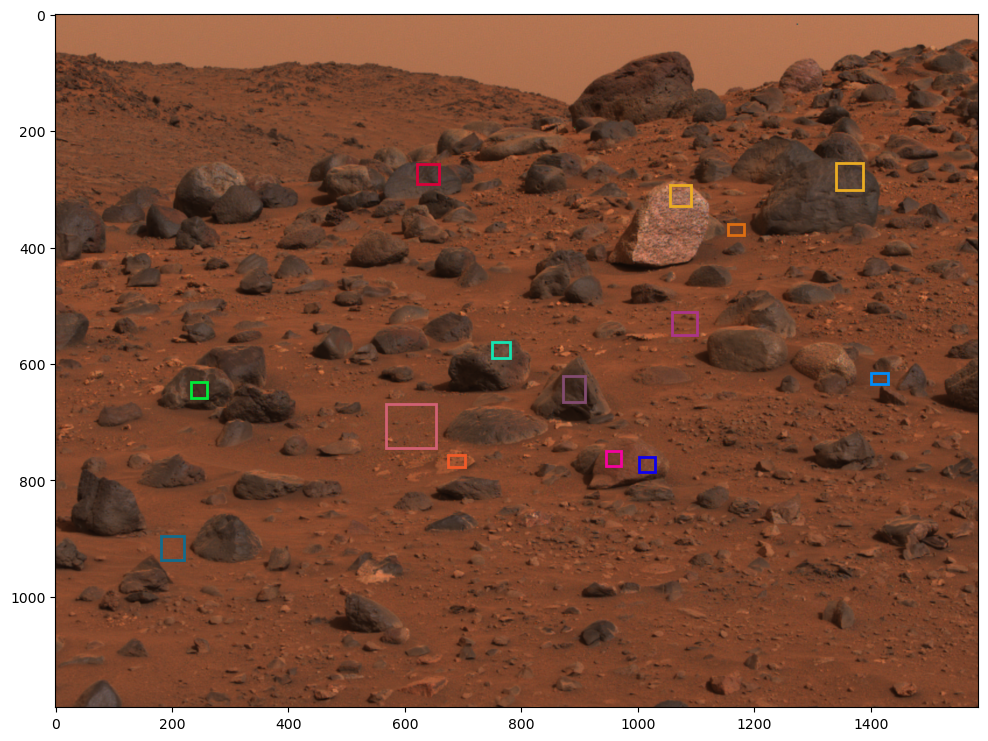

In [38]:
fig, ax = plt.subplots(figsize=(12, 9))
im = ax.imshow(rgb_normalized)

COLORS = [
        "#ebac23",
        "#D80039",
        "#008cf9",
        "#AB358A",
        "#F5029F",
        "#0E00EE",
        "#00EB39",
        "#f05a28",
        "#15E4B1",
        "#D16174",
        "#136B8C",
        "#DD6E12",
        "#834C71"
    ]

color_i = 0
for i, (x1, y1, x2, y2) in enumerate(rois):
    if i in roi_to_omit:
        continue
    
    if color_i == len(COLORS):
        color_i = 0
    
    curr_color = COLORS[color_i]
    
    roi = patches.Rectangle((x1, y1), x2, y2, edgecolor=curr_color, facecolor='none', linewidth=2)
    ax.add_patch(roi)
    
    color_i+=1

plt.show()

In [39]:
markers = [
    'o',
    's',
    '^',
    'v',
    '*',
    'D',
    'H'
]

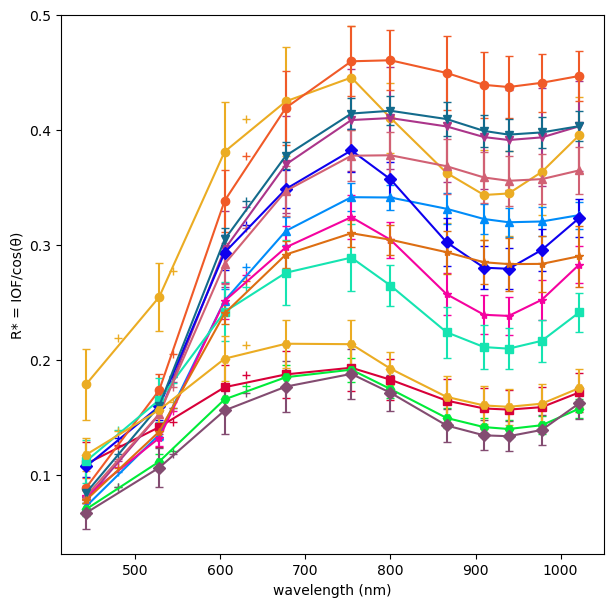

In [40]:
plot_spectra(spectra, stds, COLORS, markers)

### testing...

In [41]:
fits = pdr.read("C:\\Users\\Lars\\Downloads\\roi_SOL1376_zcam04056_RSM1458.fits.gz")

In [42]:
fits

pdr.Data(C:\Users\Lars\Downloads\roi_SOL1376_zcam04056_RSM1458.fits.gz)
keys=['GREEN LEFT', 'BLUE LEFT', 'RED LEFT', 'MAGENTA LEFT', 'CYAN LEFT', 'ORANGE LEFT', 'AZURE LEFT', 'GREEN RIGHT', 'BLUE RIGHT', 'RED RIGHT', 'MAGENTA RIGHT', 'CYAN RIGHT', 'ORANGE RIGHT', 'AZURE RIGHT']
not yet loaded: ('GREEN LEFT', 'BLUE LEFT', 'RED LEFT', 'MAGENTA LEFT', 'CYAN LEFT', 'ORANGE LEFT', 'AZURE LEFT', 'GREEN RIGHT', 'BLUE RIGHT', 'RED RIGHT', 'MAGENTA RIGHT', 'CYAN RIGHT', 'ORANGE RIGHT', 'AZURE RIGHT')

In [43]:
fits['GREEN LEFT']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1200, 1648), dtype=uint8)

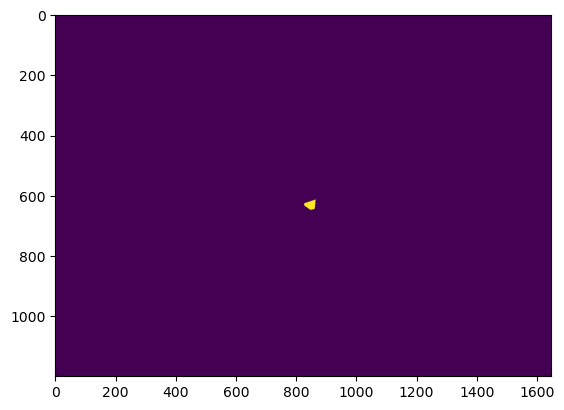

In [44]:
plt.imshow(fits['GREEN LEFT'])